In [1]:
import pandas as pd
import numpy as np
import re
import os
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.discrete.discrete_model import NegativeBinomial
from patsy.contrasts import Treatment
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pickle import dump

In [2]:
"""
Define I/O info
"""
# path to input directory
inDIR = 'C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/data/'
# file name of gridded path intensity data (output from gps_to_gridded_path_intensity.ipynb)
griddata_f = '2017_grazing_time_gridded_all_extracted.csv'

# path to output directory
outDIR = 'C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/models/'

if not os.path.exists(outDIR):
    os.mkdir(outDIR)

In [3]:
"""
Load data and check data types
"""
df_wkly_grid_full = pd.read_csv(os.path.join(inDIR, griddata_f))
display(df_wkly_grid_full.dtypes)

index_id          int64
mod_data         object
week              int64
Pasture          object
Steer_ID         object
UTM_X           float64
UTM_Y           float64
grazing_secs    float64
TPC             float64
dFence          float64
dTank           float64
PC_dmt           object
PC_pct          float64
PC_div          float64
Biomass         float64
CP              float64
DOM             float64
TPC_c            object
dCorner         float64
dtype: object

In [4]:
"""
Add season to dataset based on week
"""

def season_func(wk):
    if wk <= 26:
        return 'early'
    elif wk <= 32:
        return 'mid'
    elif wk >= 33:
        return 'late'

df_wkly_grid_full['season'] = df_wkly_grid_full['week'].apply(lambda x: season_func(x))
df_wkly_grid_full['season'] = pd.Categorical(df_wkly_grid_full['season'], ['early', 'mid', 'late'])

'Number of grazing values > 10,000 = 6'

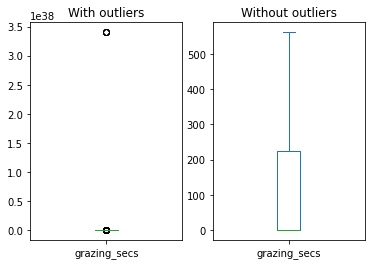

In [5]:
"""
Check grazing intensity values for further cleaning
"""
max_graze_secs = 10000
fig, axs = plt.subplots(nrows=1, ncols=2)
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=True, ax=axs[0], title='With outliers')
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=False, ax=axs[1], title='Without outliers')
display('Number of grazing values > ' + "{:,}".format(max_graze_secs) + ' = ' + "{:,}".format(
    len(df_wkly_grid_full[df_wkly_grid_full['grazing_secs'] > 10000])))

In [6]:
# mask grid cells with seemingly erroneous grazing intensity
df_wkly_grid_full.loc[df_wkly_grid_full['grazing_secs'] > max_graze_secs, 'grazing_secs'] = np.nan

In [7]:
"""
Remove data in corners and near water tanks
"""
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dTank'] > 60]
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dCorner'] > 60]

In [8]:
"""
Flag and remove any outliers beyond last 60-sec bin with only one pixel
"""

def flag_graze_outliers(x, bins=np.arange(-5, 10000, 60)):
    groups = x.groupby(pd.cut(x, bins, include_lowest=False))
    one_bins = bins[:-1][(groups.count() == 1).values] 
    gt_one_bins = bins[:-1][(groups.count() > 1).values] 
    last_one_bin = np.min([np.max(gt_one_bins) + 60, np.max([np.min(one_bins), np.max(gt_one_bins)])])
    return (x >= last_one_bin).astype('int')
    
df_wkly_grid_full['grazing_secs_outlier'] = df_wkly_grid_full.groupby(['week', 'Pasture', 'Steer_ID'])['grazing_secs'].transform(flag_graze_outliers)
print('Stats of grid cells removed across all steer-weeks:')
display(df_wkly_grid_full.groupby(['week', 'Pasture', 'Steer_ID'])['grazing_secs_outlier'].sum().describe())

Stats of grid cells removed across all steer-weeks:


count    198.000000
mean       6.171717
std        2.908208
min        2.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       19.000000
Name: grazing_secs_outlier, dtype: float64

In [9]:
# remove grazing outliers
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['grazing_secs_outlier'] == 0]

In [10]:
"""
Calculate total weekly grazing seconds per steer-week to use as offset to account for missing data
"""
# get the sum total of grazing seconds for each steer-week
df_wkly_grid_full['grazing_wkly_sum'] = df_wkly_grid_full.groupby(['Pasture', 'Steer_ID', 'week'])['grazing_secs'].transform('sum')

In [11]:
"""
Calculate grazing frequency relative to expected with perfectly even grazing
"""
df_wkly_grid_full['grazing_rel_freq'] = df_wkly_grid_full['grazing_secs'] / (df_wkly_grid_full['grazing_wkly_sum'] / 
                                                                             df_wkly_grid_full.groupby(
                                                                                 ['Pasture', 'Steer_ID', 'week'])['grazing_secs'].transform('count'))
df_wkly_grid_full['grazing_rel_freq'].describe()

count    279760.000000
mean          1.000000
std           1.826196
min           0.000000
25%           0.000000
50%           0.000000
75%           1.323287
max          55.542754
Name: grazing_rel_freq, dtype: float64

In [12]:
"""
Scale variables if desired
"""
from sklearn.preprocessing import StandardScaler
scale_vars = False
scaler = StandardScaler()
for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
    for seas in ['early', 'mid', 'late']:
        scaler.fit(df_wkly_grid_full.loc[df_wkly_grid_full['season'] == seas, c].values.reshape(-1, 1))
        with open(os.path.join(outDIR, 'scaler_' + seas + '_' + c + '.pkl'), 'wb') as f:
            dump(scaler, f)
        df_wkly_grid_full.loc[df_wkly_grid_full['season'] == seas, c] = scaler.transform(
            df_wkly_grid_full.loc[df_wkly_grid_full['season'] == seas, c].values.reshape(-1, 1)).flatten()
#for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
#    df_wkly_grid_full.loc[:, c] = df_wkly_grid_full.groupby(['season'])[c].transform(
#        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
    #scaler.fit_transform(df_wkly_grid_full[c].values.reshape(-1, 1)).flatten()#.transform(
#        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

In [13]:
"""
Organize dataset into training and testing data
"""
df_wkly_grid_test = df_wkly_grid_full[df_wkly_grid_full['mod_data'] == 'test']
df_wkly_grid = df_wkly_grid_full[df_wkly_grid_full['mod_data'] == 'train']

In [14]:
"""
Check for very rare plant community classes by pasture
"""
pc_dmt_summary = df_wkly_grid.groupby(['Steer_ID', 'Pasture', 'week'])['PC_dmt'].value_counts().groupby(
    ['Pasture', 'PC_dmt']).max().rename('value').to_frame().reset_index().pivot(index='PC_dmt', columns='Pasture')['value']
pc_dmt_summary['Total'] = pc_dmt_summary.sum(axis=1)
display(pc_dmt_summary)

Pasture,15E,17N,20SE,26E,31E,7NW,Total
PC_dmt,,,,,,,
Bare_veg,4.0,1.0,27.0,4.0,20.0,3.0,59.0
C3,NaN,27.0,475.0,3.0,13.0,1.0,519.0
C3_C4_mix,371.0,535.0,339.0,92.0,734.0,945.0,3016.0
C4,1060.0,373.0,243.0,1265.0,844.0,357.0,4142.0
Saltgrass,NaN,439.0,318.0,NaN,5.0,72.0,834.0
Shrub,NaN,2.0,14.0,NaN,NaN,11.0,27.0
UNK,NaN,10.0,9.0,17.0,11.0,2.0,49.0


In [15]:
"""
Check for very rare topographic position classes by pasture
"""
tpc_dmt_summary = df_wkly_grid.groupby(['Pasture', 'week'])['TPC_c'].value_counts().groupby(
    ['Pasture', 'TPC_c']).max().rename('value').to_frame().reset_index().pivot(index='TPC_c', columns='Pasture')['value']
tpc_dmt_summary['Total'] = tpc_dmt_summary.sum(axis=1)
display(tpc_dmt_summary)

Pasture,15E,17N,20SE,26E,31E,7NW,Total
TPC_c,,,,,,,
Flat Plains,691.0,342.0,1316.0,841.0,154.0,1900.0,5244.0
Highlands,582.0,578.0,88.0,102.0,483.0,154.0,1987.0
Lowlands,691.0,1279.0,895.0,170.0,426.0,364.0,3825.0
Open Slopes,895.0,516.0,546.0,269.0,547.0,360.0,3133.0
Other,10.0,58.0,NaN,1.0,17.0,NaN,86.0


In [16]:
"""
Combine rare classes to 'Other'
"""
#df_wkly_grid[df_wkly_grid['PC_dmt'].isin(['Bare', 'Bare_veg', 'UNK', 'Shrub'])] = 'Other'
df_wkly_grid['PC_dmt'].replace({'Bare_veg': 'Other', 'Bare': 'Other', 'UNK': 'Other', 'Shrub': 'Other'}, 
                               inplace=True)
#df_wkly_grid = df_wkly_grid[~df_wkly_grid['TPC_c'].isin(['Other'])]

# print final class numbers
print(df_wkly_grid['TPC_c'].value_counts())
print('\n')
print(df_wkly_grid['PC_dmt'].value_counts())

Flat Plains    35745
Lowlands       27128
Open Slopes    22953
Highlands      14846
Other            630
Name: TPC_c, dtype: int64


C4           46353
C3_C4_mix    35660
Saltgrass    11131
C3            6681
Other         1477
Name: PC_dmt, dtype: int64


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\generic.py:6610: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [34]:
min_class_n = 10
fit_method = 'newton'
max_iters = 1000
aicw_func = lambda x: np.exp(-0.5 * (x - x.min())) / np.sum(np.exp(-0.5 * (x - x.min())))
aicd_func = lambda x: x - x.min()

m0 = 'grazing_secs ~ dFence + dTank'
m1 = m0 + ' + C(TPC_c, Treatment(reference="Flat Plains"))'
m2a = m0 + ' + Biomass'
m2b = m0 + ' + Biomass + I(Biomass**2)'
m2c = m0 + ' + CP'
m2d = m2a + ' + CP' 
m2e = m2a + ' + CP + Biomass:CP'
m2f = m2b + ' + CP'
m2g = m2b + ' + CP + Biomass:CP'
m3a = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix"))'
m3b = m0 + ' + PC_div'
m3c = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) + PC_div'
m3d = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) * PC_div'

model_dict = {
    'M0': m0,
    'M1': m1,
    'M2a': m2a,
    'M2b': m2b,
    'M2c': m2c,
    'M2d': m2d,
    'M2e': m2e,
    'M2f': m2f,
    'M2g': m2g,
    'M3a': m3a,
    'M3b': m3b,
    'M3c': m3c,
    'M3d': m3d
}

In [35]:
"""
Run the initial candidate models
"""
df_results = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC'])
idx = 0
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture', 'Steer_ID'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC'])
    
    # run initial models for negative binomial
    for i in model_dict:
        form = model_dict[i]
        #print('NB: ' + form)
        try:
            md_tmp3 = NegativeBinomial.from_formula(form, data, 
                                                    offset=np.log(data['grazing_wkly_sum']), missing='drop')
            mdf_tmp3 = md_tmp3.fit(maxiter=max_iters, method=fit_method, disp=False)
            if mdf_tmp3.mle_retvals['converged']:
                aic_tmp = round(mdf_tmp3.aic, 2)
            else:
                aic_tmp = np.nan
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'Steer_ID': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/71 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:861: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred) # not cdf
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2850: RuntimeWarning: invalid value encountered in true_divide
  const_arr = a1*mu*(a1+y)/(mu+a1)**2
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: invalid value encountered in multiply
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: invalid value encountered in true_divide
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2870: RuntimeWarning: divide by zero encountered in log
  np

In [36]:
"""
Analyze the top forage condition models
"""
# calculate AIC weights for the forage condition models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICw_FC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICd_FC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_FC'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_FC'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_FC'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_FC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_FC': np.mean, 'AICw_FC': np.mean, 
          'top_model_FC': np.max, 'candidate_model_FC': np.max}).groupby(
    ['season', 'model'])[['top_model_FC', 'candidate_model_FC', 'AICw_FC', 'AICd_FC']].aggregate(
    func={'AICd_FC': [np.median, np.std], 'AICw_FC': [np.mean, np.std], 
          'top_model_FC': np.sum, 'candidate_model_FC': np.sum}, axis=1).sort_values(['season', ('AICd_FC', 'median')]))

# print the results by pasture
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_FC': np.mean, 'AICw_FC': np.mean, 
          'top_model_FC': np.max, 'candidate_model_FC': np.max}).groupby(
    ['Pasture', 'model'])[['top_model_FC', 'candidate_model_FC', 'AICw_FC', 'AICd_FC']].aggregate(
    func={'AICd_FC': [np.median, np.std], 'AICw_FC': [np.mean, np.std], 
          'top_model_FC': np.sum, 'candidate_model_FC': np.sum}, axis=1).sort_values(['Pasture', ('AICd_FC', 'median')]))

display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_FC': np.mean, 'AICw_FC': np.mean, 
          'top_model_FC': np.max, 'candidate_model_FC': np.max}).groupby(
    ['model'])[['top_model_FC', 'candidate_model_FC', 'AICw_FC', 'AICd_FC']].aggregate(
    func={'AICd_FC': [np.median, np.std], 'AICw_FC': [np.mean, np.std], 
          'top_model_FC': np.sum, 'candidate_model_FC': np.sum}, axis=1).sort_values(('AICd_FC', 'median')))

AICd_FC              AICw_FC           top_model_FC  \
               median        std      mean       std          sum   
season model                                                        
early  M2g     1.8175   1.387631  0.166664  0.105203          1.0   
       M2d     1.9800   3.908128  0.146661  0.094066          2.0   
       M2e     2.3925   2.450058  0.187621  0.161644          5.0   
       M2f     2.5225   1.942346  0.186185  0.147183          5.0   
       M2b     4.2550   6.724311  0.102060  0.095718          0.0   
       M2a     6.3525  10.102104  0.100114  0.141638          4.0   
       M2c     9.5075  17.399778  0.110695  0.158862          6.0   
mid    M2g     1.6950   1.368091  0.370701  0.344783          8.0   
       M2e     1.8200   4.489526  0.159635  0.144123          1.0   
       M2f     1.9700   4.442168  0.176471  0.141073          4.0   
       M2d     4.3275   5.651120  0.156723  0.153488          4.0   
       M2a    10.8400  15.469862  0.028285  0.071911          1.0   
       M2b    11.8700  15.184967  0.070221  0.154595          1.0   
       M2c    17.0900  16.050970  0.046832  0.105719          2.0   
late   M2f     1.8550   1.116408  0.177830  0.092993          2.0   
       M2g     2.3500   1.456735  0.196143  0.201840          3.0   
       M2b     2.5000   4.213357  0.160163  0.141015          3.0   
       M2c     2.5450  22.498397  0.115506  0.110772          3.0   
       M2d     2.7200   4.730391  0.121458  0.091340          2.0   
       M2a     2.7750   6.278020  0.137872  0.100373          4.0   
       M2e     3.1050   2.389818  0.091029  0.054793          0.0   

             candidate_model_FC  
                            sum  
season model                     
early  M2g                 11.0  
       M2d                 12.0  
       M2e                 10.0  
       M2f                  9.0  
       M2b                  8.0  
       M2a                  4.0  
       M2c                  6.0  
mid    M2g                 13.0  
       M2e                 10.0  
       M2f                 11.0  
       M2d                 11.0  
       M2a                  2.0  
       M2b                  3.0  
       M2c                  3.0  
late   M2f                 10.0  
       M2g                  5.0  
       M2b                  9.0  
       M2c                  6.0  
       M2d                  7.0  
       M2a                  8.0  
       M2e                  5.0

AICd_FC              AICw_FC           top_model_FC  \
                median        std      mean       std          sum   
Pasture model                                                        
15E     M2g     2.1600   1.292311  0.235806  0.164120          3.0   
        M2f     2.4525   1.809206  0.172307  0.111262          1.0   
        M2e     4.2900   3.183640  0.146485  0.112584          1.0   
        M2d     4.8925   3.618024  0.129139  0.077220          1.0   
        M2b     5.0650   2.937158  0.122304  0.148167          1.0   
        M2a     6.0575   4.367597  0.089647  0.134912          2.0   
        M2c     9.6150   9.787835  0.104312  0.146040          3.0   
17N     M2g     0.8800   1.320543  0.472414  0.395167          4.0   
        M2e     2.4550   5.390567  0.135467  0.125093          2.0   
        M2f     2.7300   4.472643  0.139935  0.108762          1.0   
        M2d     6.5000   6.764039  0.108714  0.119464          2.0   
        M2c    14.4300  20.227678  0.099296  0.131129          3.0   
        M2b    21.1775  17.655725  0.026322  0.036413          0.0   
        M2a    29.2900  18.893314  0.034786  0.065679          1.0   
20SE    M2f     0.1200   1.320974  0.341319  0.127734          5.0   
        M2g     1.4600   1.111750  0.272213  0.165526          2.0   
        M2b     3.1175   6.423705  0.198606  0.209221          2.0   
        M2d     6.0250   4.763341  0.069654  0.070288          0.0   
        M2e     6.2125   2.933953  0.082437  0.146756          1.0   
        M2a     9.4025   5.362894  0.027328  0.038184          0.0   
        M2c    13.2575  29.173660  0.008444  0.019943          0.0   
26E     M2d     0.7000   1.681194  0.220434  0.130603          2.0   
        M2f     1.3550   1.133565  0.196067  0.093434          2.0   
        M2e     1.3750   1.253611  0.176180  0.097893          0.0   
        M2g     2.0450   1.256878  0.161557  0.135400          1.0   
        M2b     5.0900  11.678868  0.084953  0.100946          0.0   
        M2a     7.0800  10.750664  0.085978  0.143138          2.0   
        M2c    10.7600  16.093299  0.074832  0.133130          1.0   
31E     M2a     1.1800  12.890648  0.162357  0.141913          2.0   
        M2d     1.9100   4.908036  0.128478  0.096526          1.0   
        M2e     2.0250   2.836877  0.143209  0.130944          0.0   
        M2b     2.0300  12.640767  0.095870  0.086439          0.0   
        M2g     2.7150   1.672797  0.247091  0.339868          2.0   
        M2f     3.3800   4.373638  0.096716  0.122403          1.0   
        M2c     3.9150  10.281419  0.126279  0.140476          2.0   
7NW     M2d     1.3550   3.726337  0.208382  0.147946          2.0   
        M2e     1.4875   1.762625  0.231069  0.193217          2.0   
        M2f     2.3875   2.297217  0.136378  0.091616          1.0   
        M2g     3.3225   1.348148  0.114205  0.090552          0.0   
        M2b     4.7325   9.341201  0.099823  0.130992          1.0   
        M2a     5.9325   9.147113  0.095609  0.111734          2.0   
        M2c     8.2050   8.557149  0.114534  0.167202          2.0   

              candidate_model_FC  
                             sum  
Pasture model                     
15E     M2g                  6.0  
        M2f                  6.0  
        M2e                  5.0  
        M2d                  6.0  
        M2b                  4.0  
        M2a                  2.0  
        M2c                  3.0  
17N     M2g                  6.0  
        M2e                  4.0  
        M2f                  5.0  
        M2d                  4.0  
        M2c                  3.0  
        M2b                  1.0  
        M2a                  2.0  
20SE    M2f                  7.0  
        M2g                  7.0  
        M2b                  5.0  
        M2d                  3.0  
        M2e                  1.0  
        M2a                  1.0  
        M2c                  0.0  
26E     M2d             

AICd_FC              AICw_FC           top_model_FC candidate_model_FC
        median        std      mean       std          sum                sum
model                                                                        
M2g     1.8575   1.407326  0.250548  0.255959         12.0               29.0
M2d     2.0325   4.813274  0.144134  0.117766          8.0               30.0
M2f     2.0600   3.088291  0.180454  0.130684         11.0               30.0
M2e     2.5550   3.353520  0.152836  0.138152          6.0               25.0
M2b     4.7475  11.851107  0.104646  0.133625          4.0               20.0
M2a     7.3700  12.973425  0.082617  0.116241          9.0               14.0
M2c    12.1725  18.247577  0.087949  0.130699         11.0               15.0

In [22]:
M2_subset = ['M2a', 'M2b', 'M2c', 'M2d', 'M2e', 'M2f']
df_results_m2_simp = df_results.copy(deep=True)

df_results_m2_simp.loc[df_results_m2_simp['model'].str.contains(
    '|'.join(M2_subset)), 
               'AICw_FC'] = df_results_m2_simp.loc[df_results_m2_simp['model'].str.contains(
    '|'.join(M2_subset))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results_m2_simp.loc[df_results_m2_simp['model'].str.contains(
    '|'.join(M2_subset)), 
               'AICd_FC'] = df_results_m2_simp.loc[df_results_m2_simp['model'].str.contains(
    '|'.join(M2_subset))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results_m2_simp['top_model_FC'] = df_results_m2_simp.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_FC'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results_m2_simp['candidate_model_FC'] = df_results_m2_simp.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_FC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results_m2_simp.loc[df_results_m2_simp['model'].str.contains(
    '|'.join(M2_subset))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_FC': np.mean, 'AICw_FC': np.mean, 
          'top_model_FC': np.max, 'candidate_model_FC': np.max}).groupby(
    ['season', 'model'])[['top_model_FC', 'candidate_model_FC', 'AICw_FC', 'AICd_FC']].aggregate(
    func={'AICd_FC': [np.median, np.std], 'AICw_FC': [np.mean, np.std], 
          'top_model_FC': np.sum, 'candidate_model_FC': np.sum}, axis=1).sort_values(['season', ('AICd_FC', 'median')]))
display(df_results_m2_simp.loc[df_results_m2_simp['model'].str.contains(
    '|'.join(M2_subset))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_FC': np.mean, 'AICw_FC': np.mean, 
          'top_model_FC': np.max, 'candidate_model_FC': np.max}).groupby(
    ['model'])[['top_model_FC', 'candidate_model_FC', 'AICw_FC', 'AICd_FC']].aggregate(
    func={'AICd_FC': [np.median, np.std], 'AICw_FC': [np.mean, np.std], 
          'top_model_FC': np.sum, 'candidate_model_FC': np.sum}, axis=1).sort_values(('AICd_FC', 'median')))

AICd_FC              AICw_FC           top_model_FC  \
               median        std      mean       std          sum   
season model                                                        
early  M2d     1.8400   3.925089  0.170171  0.113039          2.0   
       M2e     2.4700   2.445878  0.235483  0.227931          5.0   
       M2f     2.5250   1.961912  0.245884  0.213320          6.0   
       M2b     4.3275   6.579323  0.118912  0.117187          0.0   
       M2a     6.3525   9.980458  0.107755  0.149953          4.0   
       M2c     9.5075  17.397174  0.121794  0.173453          6.0   
mid    M2f     1.1800   3.009029  0.346498  0.251032          6.0   
       M2d     1.3700   4.472976  0.238215  0.160345          4.0   
       M2e     1.7650   3.171325  0.237255  0.229415          3.0   
       M2a    10.8000  13.536941  0.034536  0.088067          1.0   
       M2b    11.2450  13.262284  0.090494  0.181826          1.0   
       M2c    15.7050  14.346358  0.053002  0.119860          2.0   
late   M2f     1.7600   1.281323  0.267121  0.230405          4.0   
       M2b     1.9500   3.498742  0.195218  0.163448          3.0   
       M2a     2.5225   5.581117  0.154582  0.102492          4.0   
       M2d     2.5350   4.051343  0.141950  0.093485          2.0   
       M2c     2.5450  21.769766  0.125898  0.120379          3.0   
       M2e     2.6925   2.148900  0.115230  0.079436          1.0   

             candidate_model_FC  
                            sum  
season model                     
early  M2d                 12.0  
       M2e                  9.0  
       M2f                  9.0  
       M2b                  7.0  
       M2a                  4.0  
       M2c                  6.0  
mid    M2f                 15.0  
       M2d                 13.0  
       M2e                 13.0  
       M2a                  2.0  
       M2b                  3.0  
       M2c                  3.0  
late   M2f                  9.0  
       M2b                  8.0  
       M2a                  8.0  
       M2d                  7.0  
       M2c                  6.0  
       M2e                  4.0

AICd_FC              AICw_FC           top_model_FC candidate_model_FC
        median        std      mean       std          sum                sum
model                                                                        
M2f     1.7525   2.265292  0.288924  0.231900         16.0               33.0
M2d     1.8525   4.086877  0.188632  0.132647          8.0               32.0
M2e     2.5475   2.660102  0.206084  0.205221          9.0               26.0
M2b     4.2075  10.401734  0.127332  0.157802          4.0               18.0
M2a     7.3700  11.620665  0.092005  0.125525          9.0               14.0
M2c    11.5700  17.347419  0.097023  0.143736         11.0               15.0

In [37]:
"""
Analyze the top plant community models
"""
# calculate AIC weights and delta for the plant community models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICw_PC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICd_PC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_PC'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_PC'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_PC'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_PC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_PC': np.mean, 'AICw_PC': np.mean, 
          'top_model_PC': np.max, 'candidate_model_PC': np.max}).groupby(
    ['season', 'model'])[['top_model_PC', 'candidate_model_PC', 'AICw_PC', 'AICd_PC']].aggregate(
    func={'AICd_PC': [np.median, np.std], 'AICw_PC': [np.mean, np.std],
          'top_model_PC': np.sum, 'candidate_model_PC': np.sum}, axis=1).sort_values(['season', ('AICd_PC', 'median')]))

# print the results by pasture
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_PC': np.mean, 'AICw_PC': np.mean, 
          'top_model_PC': np.max, 'candidate_model_PC': np.max}).groupby(
    ['Pasture', 'model'])[['top_model_PC', 'candidate_model_PC', 'AICw_PC', 'AICd_PC']].aggregate(
    func={'AICd_PC': [np.median, np.std], 'AICw_PC': [np.mean, np.std],
          'top_model_PC': np.sum, 'candidate_model_PC': np.sum}, axis=1).sort_values(['Pasture', ('AICd_PC', 'median')]))

display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_PC': np.mean, 'AICw_PC': np.mean, 
          'top_model_PC': np.max, 'candidate_model_PC': np.max}).groupby(
    ['model'])[['top_model_PC', 'candidate_model_PC', 'AICw_PC', 'AICd_PC']].aggregate(
    func={'AICd_PC': [np.median, np.std], 'AICw_PC': [np.mean, np.std], 
          'top_model_PC': np.sum, 'candidate_model_PC': np.sum}, axis=1).sort_values(('AICd_PC', 'median')))

AICd_PC              AICw_PC           top_model_PC  \
               median        std      mean       std          sum   
season model                                                        
early  M3d     1.1950   2.891297  0.420361  0.365227          9.0   
       M3c     1.4200   4.582817  0.272504  0.215228          7.0   
       M3b     5.8300   7.594944  0.206195  0.272184          6.0   
       M3a    10.5250  11.103934  0.100940  0.143439          2.0   
mid    M3b     0.7875  10.791515  0.286531  0.277545          9.0   
       M3c     2.0750   4.591483  0.205066  0.177306          2.0   
       M3a     3.0250   5.462952  0.249054  0.222819          5.0   
       M3d     3.4525   2.893370  0.263835  0.346444          4.0   
late   M3b     0.0000   8.881428  0.386858  0.288302          8.0   
       M3c     2.7875   2.388689  0.192124  0.113800          1.0   
       M3a     2.8375  11.365220  0.186655  0.144199          1.0   
       M3d     3.7700   2.715559  0.273041  0.325814          4.0   

             candidate_model_PC  
                            sum  
season model                     
early  M3d                 12.0  
       M3c                 10.0  
       M3b                  8.0  
       M3a                  4.0  
mid    M3b                 10.0  
       M3c                  9.0  
       M3a                  8.0  
       M3d                  7.0  
late   M3b                  8.0  
       M3c                  7.0  
       M3a                  5.0  
       M3d                  6.0

AICd_PC              AICw_PC           top_model_PC  \
                median        std      mean       std          sum   
Pasture model                                                        
15E     M3b     0.7875  10.193159  0.257563  0.213453          4.0   
        M3d     1.5875   1.536975  0.395820  0.372725          3.0   
        M3c     1.7175   3.350010  0.200236  0.120505          1.0   
        M3a     6.5150  12.968559  0.146381  0.168984          2.0   
17N     M3d     0.1525   2.133209  0.574414  0.394281          6.0   
        M3a     3.1275   5.634498  0.222129  0.228890          2.0   
        M3c     4.3375   4.727906  0.156940  0.159437          1.0   
        M3b     9.4325  12.957312  0.114628  0.187145          2.0   
20SE    M3d     0.7175   1.877283  0.417692  0.308162          5.0   
        M3c     0.7350   3.205745  0.399365  0.201947          4.0   
        M3b    13.1550   9.271205  0.150628  0.237991          2.0   
        M3a    14.6200  14.286027  0.032315  0.041265          0.0   
26E     M3b     0.0000   1.757160  0.452945  0.215132          7.0   
        M3c     1.6650   1.447184  0.273351  0.184042          1.0   
        M3a     2.4700   5.585471  0.162391  0.146546          0.0   
        M3d     4.0000   2.542468  0.111312  0.111091          0.0   
31E     M3b     0.0000   6.013281  0.447346  0.360154          5.0   
        M3a     2.6900   4.473228  0.227473  0.179547          1.0   
        M3c     4.5100   4.187633  0.091119  0.075870          0.0   
        M3d     5.5500   3.723983  0.234062  0.384409          2.0   
7NW     M3c     1.9850   5.591357  0.241708  0.182500          3.0   
        M3a     2.5450   4.984326  0.276779  0.231052          3.0   
        M3d     4.1500   2.977481  0.215703  0.329381          1.0   
        M3b     5.9550   6.840385  0.265810  0.317341          3.0   

              candidate_model_PC  
                             sum  
Pasture model                     
15E     M3b                  5.0  
        M3d                  6.0  
        M3c                  6.0  
        M3a                  4.0  
17N     M3d                  6.0  
        M3a                  4.0  
        M3c                  3.0  
        M3b                  3.0  
20SE    M3d                  5.0  
        M3c                  7.0  
        M3b                  2.0  
        M3a                  0.0  
26E     M3b                  7.0  
        M3c                  4.0  
        M3a                  3.0  
        M3d                  3.0  
31E     M3b                  5.0  
        M3a                  2.0  
        M3c                  1.0  
        M3d                  2.0  
7NW     M3c                  5.0  
        M3a                  4.0  
        M3d                  3.0  
        M3b                  4.0

AICd_PC             AICw_PC           top_model_PC candidate_model_PC
       median       std      mean       std          sum                sum
model                                                                      
M3c     2.090  4.074864  0.227120  0.180125         10.0               26.0
M3d     2.380  2.837910  0.324834  0.349443         17.0               25.0
M3b     2.970  9.100017  0.281487  0.281296         23.0               26.0
M3a     3.615  9.890286  0.177911  0.185724          8.0               17.0

<AxesSubplot:xlabel='PC_dmt', ylabel='PC_div'>

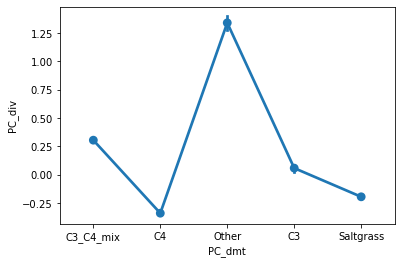

In [31]:
plt.figure()
sns.pointplot(x='PC_dmt', y='PC_div', data=df_wkly_grid)

In [40]:
"""
Define the top vegetation models
"""
m2_top = m2g
m3_top = m3d

m4a = m2_top + re.sub(re.escape(m0), '', m3_top)
m4b = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):Biomass'
m4c = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP'
m4d = m4a + ' + PC_div:Biomass'
m4e = m4a + ' + PC_div:CP'
m4f = m4b + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP'
m4g = m4d + ' + PC_div:CP'
m4h = m4b + ' + PC_div:Biomass + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP + PC_div:CP'

model_dict_veg = {
    'M4a': m4a,
    'M4b': m4b,
    'M4c': m4c,
    'M4d': m4d,
    'M4e': m4e,
    'M4f': m4f,
    'M4g': m4g,
    'M4h': m4h
}

In [41]:
"""
Run additional vegetation models
"""
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture', 'Steer_ID'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')

    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC'])
    
    # run forage condition models for negative binomial
    for i in model_dict_veg:
        form = model_dict_veg[i]
        #print('NB: ' + form)
        try:
            md_tmp3 = NegativeBinomial.from_formula(form, data, 
                                                    offset=np.log(data['grazing_wkly_sum']), missing='drop')
            mdf_tmp3 = md_tmp3.fit(maxiter=max_iters, method=fit_method, disp=False)
            if mdf_tmp3.mle_retvals['converged']:
                aic_tmp = round(mdf_tmp3.aic, 2)
            else:
                aic_tmp = np.nan
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'Steer_ID': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/71 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2850: RuntimeWarning: overflow encountered in square
  const_arr = a1*mu*(a1+y)/(mu+a1)**2
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: overflow encountered in multiply
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: overflow encountered in square
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: invalid value encountered in true_divide
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2873: RuntimeWarning: overflow encountered in

In [42]:
"""
Analyze the top vegetation models
"""
# calculate AIC weights for the forage condition models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4'])), 
               'AICw_VEG'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4'])), 
               'AICd_VEG'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_VEG'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_VEG'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_VEG'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_VEG'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_VEG': np.mean, 'AICw_VEG': np.mean, 
          'top_model_VEG': np.max, 'candidate_model_VEG': np.max}).groupby(
    ['season', 'model'])[['top_model_VEG', 'candidate_model_VEG', 'AICw_VEG', 'AICd_VEG']].aggregate(
    func={'AICd_VEG': [np.median, np.std], 'AICw_VEG': [np.mean, np.std],
          'top_model_VEG': np.sum, 'candidate_model_VEG': np.sum}, axis=1).sort_values(['season', ('AICd_VEG', 'median')]))
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_VEG': np.mean, 'AICw_VEG': np.mean, 
          'top_model_VEG': np.max, 'candidate_model_VEG': np.max}).groupby(
    ['model'])[['top_model_VEG', 'candidate_model_VEG', 'AICw_VEG', 'AICd_VEG']].aggregate(
    func={'AICd_VEG': [np.median, np.std], 'AICw_VEG': [np.mean, np.std], 
          'top_model_VEG': np.sum, 'candidate_model_VEG': np.sum}, axis=1).sort_values(('AICd_VEG', 'median')))

AICd_VEG            AICw_VEG           top_model_VEG  \
               median       std      mean       std           sum   
season model                                                        
early  M4a     1.4950  2.651116  0.218835  0.105916          12.0   
       M4d     2.0675  2.732203  0.173143  0.117961           3.0   
       M4e     2.4175  2.703481  0.123314  0.071264           2.0   
       M4g     2.7850  3.026384  0.110962  0.083485           2.0   
       M4c     3.1425  3.863170  0.151175  0.161885           5.0   
       M4b     3.4300  2.672466  0.140145  0.166185           3.0   
       M4f     5.4975  2.711991  0.051881  0.072291           1.0   
       M4h     6.9475  3.167404  0.040751  0.064569           1.0   
mid    M4a     0.1850  3.376442  0.246812  0.159243           9.0   
       M4d     1.6750  2.893584  0.204373  0.146573           4.0   
       M4e     1.8900  2.200985  0.176487  0.113147           4.0   
       M4g     2.0150  1.347630  0.163760  0.118628           1.0   
       M4c     4.0000  3.560227  0.068099  0.068092           1.0   
       M4b     4.7250  3.334095  0.069883  0.077397           2.0   
       M4f     6.6975  3.720645  0.028922  0.034660           0.0   
       M4h     8.1450  5.018119  0.050487  0.104980           0.0   
late   M4a     1.1700  1.861920  0.241658  0.143768           7.0   
       M4e     1.9700  1.905519  0.172021  0.118454           2.0   
       M4d     1.9800  2.300500  0.156180  0.082972           2.0   
       M4b     2.6975  2.254641  0.094537  0.061047           0.0   
       M4g     3.2600  2.310186  0.101323  0.064053           0.0   
       M4c     3.2725  2.018618  0.132585  0.141428           2.0   
       M4f     4.2550  4.598029  0.107424  0.188348           1.0   
       M4h     6.9350  4.433315  0.041082  0.052436           0.0   

             candidate_model_VEG  
                             sum  
season model                      
early  M4a                  16.0  
       M4d                  13.0  
       M4e                  15.0  
       M4g                   9.0  
       M4c                   9.0  
       M4b                   8.0  
       M4f                   1.0  
       M4h                   2.0  
mid    M4a                  13.0  
       M4d                  14.0  
       M4e                  15.0  
       M4g                  12.0  
       M4c                   3.0  
       M4b                   4.0  
       M4f                   2.0  
       M4h                   3.0  
late   M4a                   9.0  
       M4e                   9.0  
       M4d                   9.0  
       M4b                   4.0  
       M4g                   5.0  
       M4c                   4.0  
       M4f                   3.0  
       M4h                   1.0

AICd_VEG            AICw_VEG           top_model_VEG candidate_model_VEG
        median       std      mean       std           sum                 sum
model                                                                         
M4a     1.0800  2.761049  0.234891  0.134826          28.0                38.0
M4d     1.8150  2.656727  0.181133  0.122327           9.0                36.0
M4e     1.9800  2.379787  0.155077  0.101495           8.0                39.0
M4g     2.5700  2.390682  0.128926  0.097220           3.0                26.0
M4b     3.4300  2.893320  0.102736  0.120200           5.0                16.0
M4c     3.5525  3.397560  0.114625  0.130859           8.0                16.0
M4f     5.6600  3.528202  0.054964  0.100765           2.0                 6.0
M4h     7.2650  4.128604  0.044367  0.078040           1.0                 6.0

In [43]:
"""
Define full models with TPC
"""
m4_top = m4a

m2_tpc = m2_top + re.sub(re.escape(m0), '', m1)
m3_tpc = m3_top + re.sub(re.escape(m0), '', m1)
m5 = m4_top + re.sub(re.escape(m0), '', m1)

tpc_mod_dict = {
    'M2_tpc': m2_tpc,
    'M3_tpc': m3_tpc,
    'M5': m5
}

In [50]:
"""
Run TPC models
"""
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture', 'Steer_ID'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'Steer_ID', 'model', 'formula', 'AIC'])
    
    # run TPC models for negative binomial
    for i in tpc_mod_dict:
        form = tpc_mod_dict[i]
        #print('NB: ' + form)
        try:
            md_tmp3 = NegativeBinomial.from_formula(form, data, 
                                                    offset=np.log(data['grazing_wkly_sum']), missing='drop')
            mdf_tmp3 = md_tmp3.fit(maxiter=max_iters, method=fit_method, disp=False)
            if mdf_tmp3.mle_retvals['converged']:
                aic_tmp = round(mdf_tmp3.aic, 2)
            else:
                aic_tmp = np.nan
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'Steer_ID': group[0][2],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/71 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:861: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred) # not cdf
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2850: RuntimeWarning: invalid value encountered in true_divide
  const_arr = a1*mu*(a1+y)/(mu+a1)**2
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: invalid value encountered in multiply
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: invalid value encountered in true_divide
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2870: RuntimeWarning: divide by zero encountered in log
  np

In [51]:
"""
Calculate results for final models
"""
# calculate AIC weights for the topography interaction models
df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5), 
               'AICw_ALL'] = df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5)].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicw_func)
df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5), 
               'AICd_ALL'] = df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5)].groupby(['week', 'Pasture', 'Steer_ID'])['AIC'].transform(
    aicd_func)
df_results['top_model_ALL'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICw_ALL'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_ALL'] = df_results.groupby(['week', 'Pasture', 'Steer_ID'])['AICd_ALL'].transform(
    lambda x: [int(i) for i in x <= 2.0])

display(df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5)].groupby(
    ['season', 'week', 'model', 'Pasture']).aggregate(
    func={'AICd_ALL': np.mean, 'AICw_ALL': np.mean, 
          'top_model_ALL': np.max, 'candidate_model_ALL': np.max}).groupby(
    ['model'])[['top_model_ALL', 'candidate_model_ALL', 
                'AICw_ALL', 'AICd_ALL']].aggregate(
    func={'AICd_ALL': [np.median, np.std], 'AICw_ALL': [np.mean, np.std], 
          'top_model_ALL': np.sum, 'candidate_model_ALL': np.sum}, axis=1).sort_values(('AICd_ALL', 'median')))

AICd_ALL             AICw_ALL           top_model_ALL  \
        median        std      mean       std           sum   
model                                                         
M5      2.5750   4.958740  0.362409  0.363294          21.0   
M4a     5.7600   6.560914  0.184916  0.220041          10.0   
M2g     7.5300  12.788491  0.238341  0.344257          13.0   
M1     14.6650  20.374449  0.080872  0.204923           5.0   
M3d    17.6725  14.648802  0.096134  0.238770           5.0   
M0     22.2450  23.275002  0.059574  0.179334           4.0   

      candidate_model_ALL  
                      sum  
model                      
M5                   23.0  
M4a                  16.0  
M2g                  16.0  
M1                    6.0  
M3d                   8.0  
M0                    5.0

In [53]:
"""
Extract coefficients for each pasture-week for top models and other models of interest
"""
top_mod_dict = {
    'M0': m0,
    'M1': m1,
    'M2_bm': m2a,
    'M2_top': m2_top,
    'M3_pc': m3a,
    'M3_top': m3_top,
    'M4_top': m4_top,
    'M5_top': m5
}
idx = 0
for mod in tqdm(top_mod_dict):
    form = top_mod_dict[mod]
    for seas in df_wkly_grid['season'].unique():
        for group in df_wkly_grid[df_wkly_grid['season'] == seas].groupby(['week', 'Pasture', 'Steer_ID']):
            # remove any locations related to a class with fewer than N observations
            data = group[1]
            data['Model'] = mod
            data['Formula'] = form
            data = data[~data['PC_dmt'].isin(
                data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
            data = data[~data['TPC_c'].isin(
                data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
            md_tmp = NegativeBinomial.from_formula(form, data, offset=np.log(data['grazing_wkly_sum']), missing='drop')
            try:
                mdf_tmp = md_tmp.fit(maxiter=max_iters, method=fit_method, disp=False)
                if idx == 0:
                    if mdf_tmp.mle_retvals['converged']:
                        coefs = pd.DataFrame(dict(coef=mdf_tmp.params, 
                                                  week=group[0][0],
                                                  Pasture=group[0][1],
                                                  Steer_ID=group[0][2],
                                                  Season=seas,
                                                  Model=mod,
                                                  Formula=form))
                        idx += 1
                        df_mods_tmp = data
                    else:
                        continue
                else:
                    if mdf_tmp.mle_retvals['converged']:
                        coefs = coefs.append(pd.DataFrame(dict(coef=mdf_tmp.params, 
                                                               week=group[0][0], 
                                                               Pasture=group[0][1], 
                                                               Steer_ID=group[0][2],
                                                               Season=seas,
                                                               Model=mod,
                                                               Formula=form)))
                        idx += 1
                        df_mods_tmp = df_mods_tmp.append(data)          
                    else:
                        continue
                #print(group[0])
            except ValueError:
                pass
coefs = coefs.rename_axis('Param').reset_index()
coefs['Season'] = pd.Categorical(coefs['Season'], ['early', 'mid', 'late'])

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:861: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred) # not cdf
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2850: RuntimeWarning: invalid value encountered in true_divide
  const_arr = a1*mu*(a1+y)/(mu+a1)**2
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: invalid value encountered in multiply
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2862: RuntimeWarning: invalid value encountered in true_divide
  dldpda = -np.sum(mu*exog*(y-mu)*a1**2/(mu+a1)**2 , axis=0)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2870: RuntimeWarning: divide by zero encountered in log
  np

In [54]:
"""
Build top models for each season across all pastures
"""
seas_mod_dict = {}
for seas in coefs['Season'].unique():
    print(seas)
    seas_mod_dict[seas] = {}
    for mod in tqdm(top_mod_dict):
        form = top_mod_dict[mod]
        df_tmp = df_mods_tmp[(df_mods_tmp['season'] == seas) & (df_mods_tmp['Model'] == mod)]
        coefs_tmp = coefs[(coefs['Season'] == seas) & (coefs['Model'] == mod)][['week', 'Pasture', 'Param', 'coef']]
        md_tmp = NegativeBinomial.from_formula(form, df_tmp, offset=np.log(df_tmp['grazing_wkly_sum']), missing='drop')
        try:
            mdf_tmp = md_tmp.fit(maxiter=max_iters, method=fit_method, disp=False)
        except ValueError:
            mdf_tmp = md_tmp.fit(method="lbfgs")
        for idx, i in enumerate(mdf_tmp.params.index):
            mdf_tmp.params[idx] = coefs_tmp.groupby(
                ['week', 'Pasture', 'Param']).mean().reset_index().groupby('Param').mean().loc[i]['coef']
        coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
        mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
        mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
        seas_mod_dict[seas][mod] = mdf_tmp        

early


  0%|          | 0/8 [00:00<?, ?it/s]

mid


  0%|          | 0/8 [00:00<?, ?it/s]

late


  0%|          | 0/8 [00:00<?, ?it/s]

In [55]:
"""
Build top models for each pasture across all seasons
"""
past_mod_dict = {}
for past in coefs['Pasture'].unique():
    print(past)
    past_mod_dict[past] = {}
    for mod in tqdm(top_mod_dict):
        form = top_mod_dict[mod]
        df_tmp = df_mods_tmp[(df_mods_tmp['Pasture'] == past) & (df_mods_tmp['Model'] == mod)]
        coefs_tmp = coefs[(coefs['Pasture'] == past) & (coefs['Model'] == mod)][['Param', 'coef']]
        md_tmp = NegativeBinomial.from_formula(form, df_tmp, offset=np.log(df_tmp['grazing_wkly_sum']), missing='drop')
        try:
            mdf_tmp = md_tmp.fit(maxiter=max_iters, method=fit_method, disp=False)
        except ValueError:
            mdf_tmp = md_tmp.fit(method="lbfgs")
        #mdf_tmp.params = coefs_tmp.groupby('Param').mean().reindex(mdf_tmp.params.index)
        for idx, i in enumerate(mdf_tmp.params.index):
            mdf_tmp.params[idx] = coefs_tmp.groupby('Param').mean().loc[i]['coef']
        coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
        mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
        mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
        past_mod_dict[past][mod] = mdf_tmp        

15E


  0%|          | 0/8 [00:00<?, ?it/s]

17N


  0%|          | 0/8 [00:00<?, ?it/s]

20SE


  0%|          | 0/8 [00:00<?, ?it/s]

26E


  0%|          | 0/8 [00:00<?, ?it/s]

31E


  0%|          | 0/8 [00:00<?, ?it/s]

7NW


  0%|          | 0/8 [00:00<?, ?it/s]

In [56]:
"""
Build overall top models
"""
full_mod_dict = {}
for mod in tqdm(top_mod_dict):
    form = top_mod_dict[mod]
    df_tmp = df_mods_tmp[df_mods_tmp['Model'] == mod]
    coefs_tmp = coefs[coefs['Model'] == mod][['Param', 'coef']]
    md_tmp = NegativeBinomial.from_formula(form, df_tmp, offset=np.log(df_tmp['grazing_wkly_sum']), missing='drop')
    try:
        mdf_tmp = md_tmp.fit(maxiter=max_iters, method=fit_method, disp=False)
    except ValueError:
        mdf_tmp = md_tmp.fit(method="lbfgs")
    #mdf_tmp.params = coefs_tmp.groupby('Param').mean().reindex(mdf_tmp.params.index)
    for idx, i in enumerate(mdf_tmp.params.index):
        mdf_tmp.params[idx] = coefs_tmp.groupby('Param').mean().loc[i]['coef']
    coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
    mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
    mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
    full_mod_dict[mod] = mdf_tmp        

  0%|          | 0/8 [00:00<?, ?it/s]

In [57]:
"""
Save final training/test dataset. model results and and models to disk
"""
df_wkly_grid_full.to_csv(os.path.join(inDIR, '2017_grazing_time_gridded_all_for_model.csv'))

df_results.to_csv(os.path.join(outDIR, '2017_grazing_intensity_model_results.csv'))

for m in full_mod_dict:
    if not os.path.exists(os.path.join(outDIR, 'full/')):
        os.mkdir(os.path.join(outDIR, 'full/'))
    full_mod_dict[m].save(os.path.join(outDIR, 'full/', 'grazing_intensity_mod_2017_' + m + '.pkl'))
for seas in seas_mod_dict:
    if not os.path.exists(os.path.join(outDIR, 'seas/')):
        os.mkdir(os.path.join(outDIR, 'seas/'))
    for m in seas_mod_dict[seas]:
        seas_mod_dict[seas][m].save(os.path.join(outDIR, 'seas/', 'grazing_intensity_mod_2017_' + seas + '_' + m + '.pkl'))
for past in past_mod_dict:
    if not os.path.exists(os.path.join(outDIR, 'past/')):
        os.mkdir(os.path.join(outDIR, 'past/'))
    for m in past_mod_dict[past]:
        past_mod_dict[past][m].save(os.path.join(outDIR, 'past/', 'grazing_intensity_mod_2017_' + past + '_' + m + '.pkl'))
#for m in tpc_mod_dict:
#    if not os.path.exists(os.path.join(outDIR, 'tpc/')):
#        os.mkdir(os.path.join(outDIR, 'tpc/'))
#    full_mod_dict[m].save(os.path.join(outDIR, 'tpc/', 'grazing_intensity_mod_2017_' + m + '.pkl'))